In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import BatchNormalization, Dropout, MaxPooling2D
from keras import regularizers
from sklearn.preprocessing import OneHotEncoder

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
data = tf.keras.datasets.cifar10

In [ ]:
(X_tr, y_tr), (X_t, y_t) = data.load_data()

In [ ]:
print(f"Total samples in dataset = {len(y_tr) + len(y_t)}")
print(f"Total samples in training = {len(y_tr)}")
print(f"Total samples in testing = {len(y_t)}")

Total samples in dataset = 60000
Total samples in training = 50000
Total samples in testing = 10000


In [ ]:
print(f"Shape of images = {X_tr[0].shape}")

Shape of images = (32, 32, 3)


[6] 6


Text(0.5, 1.0, 'Image number 6274 -> frog')

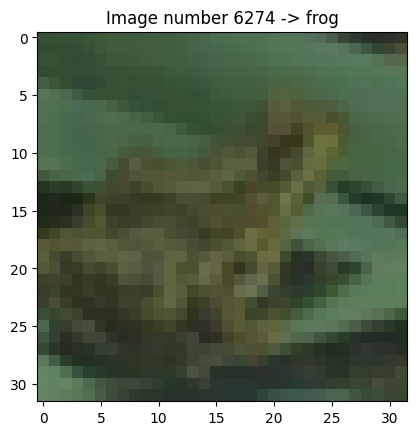

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

idx = np.random.randint(0, len(y_tr))
image, val = X_tr[idx], y_tr[idx]
plt.imshow(image)
print(val, val[0])
s = f"Image number {idx+1} -> " + labels[int(val[0])]
plt.title(s)

Text(0.5, 1.0, 'X_train distribution')

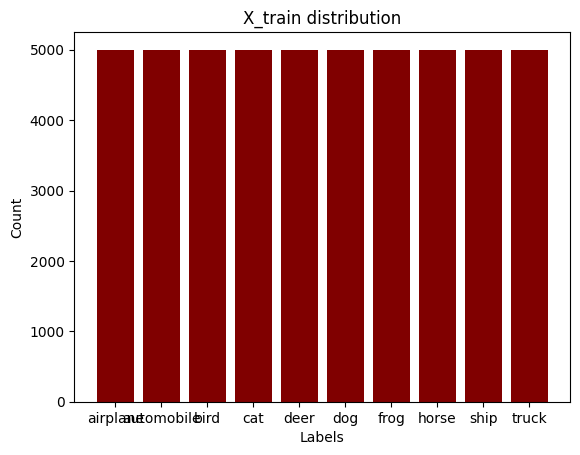

In [ ]:
count = np.zeros(10)
for _ in range(len(y_tr)):
  count[y_tr[_][0]] += 1
plt.bar(labels, count, color= 'maroon')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('X_train distribution')

In [ ]:
def preprocess_pipeline(X, y):
  print(f"X_train shape = {X.shape} | y_train shape = {y.shape}")
  X_ret = X / 255
  encoder = OneHotEncoder()
  y_ret = encoder.fit_transform(y)
  print("Categories One-Hot Encoder: ", encoder.categories_)
  print(f"After One-Hot Encoding: X_train shape = {X_ret.shape} | y_train shape = {y_ret.shape}")
  return X_ret, y_ret.toarray(), encoder

In [ ]:
enc = None
X_train, y_train, enc = preprocess_pipeline(X_tr, y_tr)

X_train shape = (50000, 32, 32, 3) | y_train shape = (50000, 1)
Categories One-Hot Encoder:  [array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)]
After One-Hot Encoding: X_train shape = (50000, 32, 32, 3) | y_train shape = (50000, 10)


**Training**

In [ ]:
def get_model(X, y):
  x_shape = X[0].shape
  y_shape = y[0].shape
  print(f"Train Shape = {X_train[0].shape} and Label Shape = {y_train[0].shape}")
  model = keras.Sequential([
                            Conv2D(32, kernel_size= (3, 3), input_shape = x_shape, activation= 'relu', padding='same', kernel_regularizer= regularizers.L2(l2=0.001)),
                            BatchNormalization(),
                            Conv2D(32, kernel_size= (3, 3), activation= 'relu', padding='same', kernel_regularizer= regularizers.L2(l2=0.001)),
                            BatchNormalization(),
                            MaxPooling2D(pool_size= (2, 2)),
                            Dropout(0.15),
                            Conv2D(64, kernel_size= (3, 4), activation= 'relu', padding='same', kernel_regularizer= regularizers.L2(l2=0.001)),
                            BatchNormalization(),
                            Conv2D(64, kernel_size= (4, 3), activation= 'relu', padding='same', kernel_regularizer= regularizers.L2(l2=0.001)),
                            BatchNormalization(),
                            MaxPooling2D(pool_size= (2, 2)),
                            Dropout(0.2),
                            Conv2D(128, kernel_size= (3, 3), activation= 'relu', padding='same', kernel_regularizer= regularizers.L2(l2=0.001)),
                            BatchNormalization(),
                            Conv2D(128, kernel_size= (3, 3), activation= 'relu', padding='same', kernel_regularizer= regularizers.L2(l2=0.001)),
                            BatchNormalization(),
                            MaxPooling2D(pool_size= (2, 2)),
                            Dropout(0.25),
                            keras.layers.Flatten(),
                            Dense(128, activation = 'relu', kernel_regularizer=regularizers.L2(0.01)),
                            keras.layers.Dropout(0.25),
                            Dense(64, activation= 'relu', kernel_regularizer=regularizers.L2(0.01)),
                            Dense(10, activation = 'softmax')
                            ])
  return model

In [ ]:
def fit_model(X, y, epochs= 10, validation_split= 0.2):
  model = get_model(X, y)
  model.compile(
      optimizer = keras.optimizers.Adam(learning_rate=0.001),
      loss = keras.losses.CategoricalCrossentropy(),
      metrics = 'accuracy'
  )
  print(model.summary())

  callbacks = [
      keras.callbacks.EarlyStopping(
          monitor="val_loss",
          min_delta=1e-3,
          patience=4,
          verbose=1,
      )
  ]

  history = None
  with tf.device('/GPU:0'):
    history = model.fit(X, y, epochs = 30, validation_split=0.2, callbacks = callbacks)
  return model, history

In [ ]:
model, history = fit_model(X_train, y_train)

Train Shape = (32, 32, 3) and Label Shape = (10,)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_22 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_23 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
   

**Saving Model**

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


**Plotting**

In [ ]:
import pandas as pd
df = pd.DataFrame(history.history)
df.head()

,loss,accuracy,val_loss,val_accuracy
0,2.576248,0.452825,1.708341,0.5592
1,1.543184,0.624100,1.553637,0.6102
2,1.405347,0.682625,1.528784,0.6656
3,1.378701,0.708250,1.338104,0.7317
4,1.351312,0.728100,1.330011,0.7316


In [ ]:
def plot_training_stats(data):
  n = len(df)
  plt.figure(figsize=(10, 7))
  plt.subplot(121)
  plt.plot([i for i in range(1, n+1)], data['loss'], c='r')
  plt.plot([i for i in range(1, n+1)], data['val_loss'], c='b')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title('Loss vs Epochs')
  plt.legend(["Loss", "Val_loss"])
  plt.subplot(122)
  plt.plot([i for i in range(1, n+1)], data['accuracy'], c='r')
  plt.plot([i for i in range(1, n+1)], data['val_accuracy'], c='b')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title('Accuracy vs Epochs')
  plt.legend(["Accuracy", "Val_Accuracy"])

  plt.show()

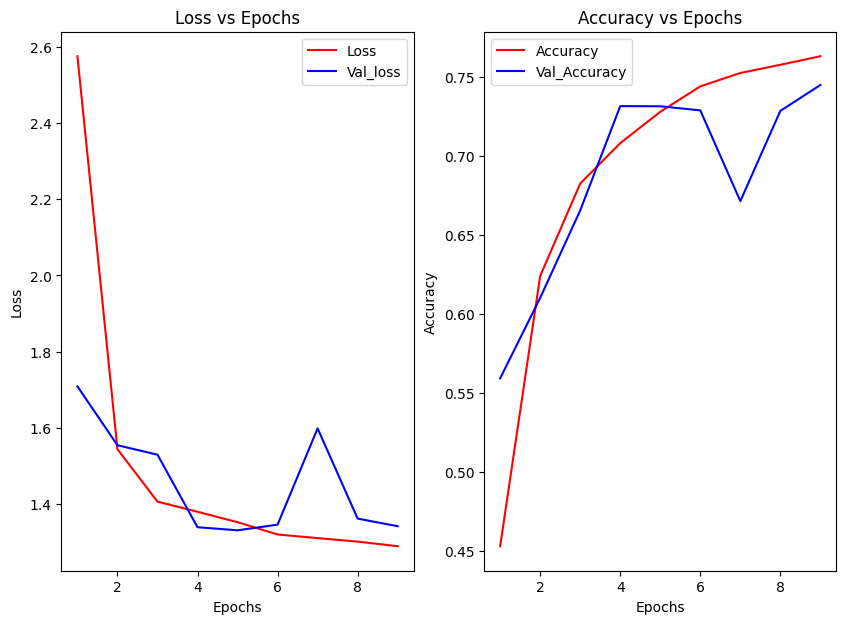

In [ ]:
plot_training_stats(df)

**Loading Pre-Trained Model**

In [ ]:
model = get_model(X_train, y_train)
model.load_weights("model.h5")

Train Shape = (32, 32, 3) and Label Shape = (10,)


**Evaluation**

In [ ]:
def evaluate(y_pred, y_true, encoder):
  corr = 0
  print(y_pred.shape, y_true.shape)
  for i in range(len(y_true)):
    if np.argmax(y_pred[i]) == y_true[i]:
      corr+=1
  return corr, corr / len(y_true)

In [ ]:
def eval_pipeline(X, y, enc, mdl):
  X_t = X / 255
  y_t = enc.transform(y)
  y_preds = mdl.predict(X_t)
  c, a = evaluate(y_preds, y, enc)
  print(f"Correct = {c} | Accuracy = {a}")
  return y_preds

In [ ]:
preds = eval_pipeline(X_t, y_t, enc, model)

313/313 [==============================] - 1s 4ms/step
(10000, 10) (10000, 1)
Correct = 7444 | Accuracy = 0.7444


In [ ]:
pred_lbls = np.argmax(preds, axis = 1)
n, m = len(labels), len(pred_lbls)
matrix = np.zeros((n, n))
for _ in range(m):
  matrix[pred_lbls[_]][y_t[_]] += 1

Text(0.5, 1.0, 'Confusion Matrix')

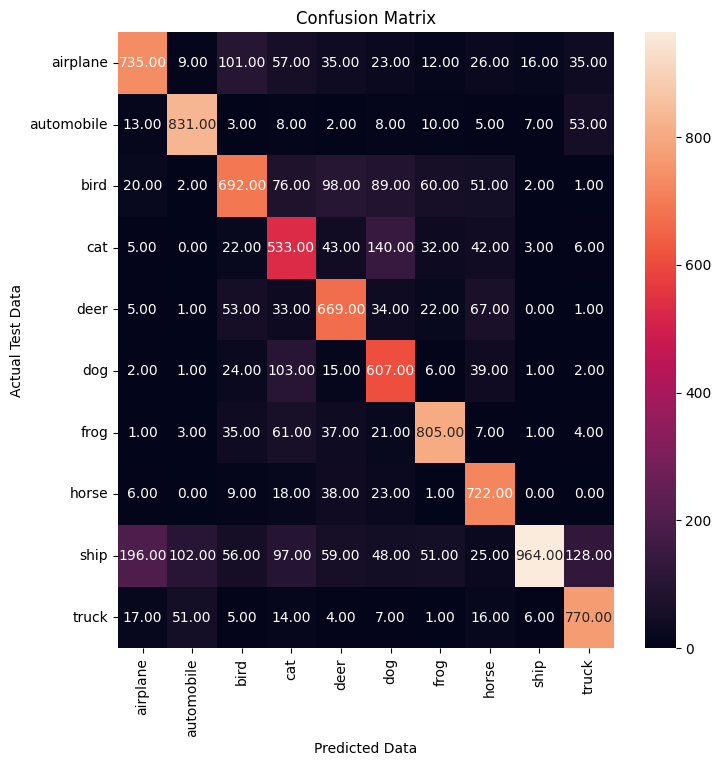

In [ ]:
import seaborn as sns
plt.figure(figsize= (8, 8))
sns.heatmap(matrix, annot=True, fmt= '.2f', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Data")
plt.ylabel("Actual Test Data")
plt.title("Confusion Matrix")

**Testing**

In [ ]:
def random_testing(X, y, lbl, y_preds= None):
  n = len(y)
  idx = np.random.randint(0, n)
  image, val = X[idx], int(y[idx][0])
  plt.imshow(image)
  s = f"Image number {idx+1} -> " + lbl[val]
  plt.title(s)

  if len(y_preds) != 0:
    pred_val = int(np.argmax(y_preds[idx]))
    print(f"Predicted Value = {lbl[pred_val]} | True Value = {lbl[val]} | Verdict = {True if pred_val == val else False}")

Predicted Value = cat | True Value = cat | Verdict = True


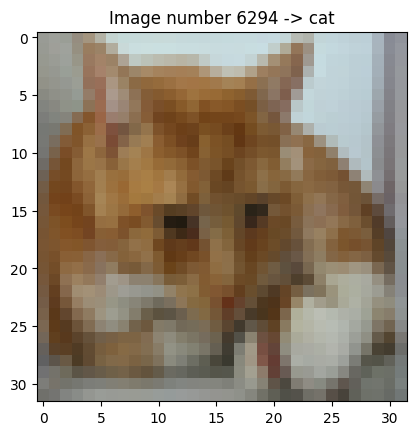

In [ ]:
random_testing(X_t, y_t, labels, preds)